http://dfedorov.spb.ru/pandas/%D0%9F%D0%BE%D0%B4%D1%80%D0%BE%D0%B1%D0%BD%D0%BE%D0%B5%20%D1%80%D1%83%D0%BA%D0%BE%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D0%BE%20%D0%B3%D1%80%D1%83%D0%BF%D0%BF%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B5%20%D0%B8%20%D0%B0%D0%B3%D1%80%D0%B5%D0%B3%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D1%8E%20%D1%81%20%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E%20pandas.html


In [1]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

In [2]:
connect = sqlite3.connect('../data/checking-logs.sqlite')

Посмотрим, какие таблицы есть в базе test и control это таблицы, которые мы сами создали (выборки)

In [3]:
a = connect.cursor().execute('SELECT name from sqlite_master where type= "table"')
print(a.fetchall())

[('pageviews',), ('checker',), ('deadlines',), ('test',), ('control',)]


Создадим таблицу с количеством коммитов

In [4]:
query = '''
SELECT uid, COUNT(*) AS num_commits
FROM checker
WHERE uid LIKE 'user_%'
AND labname <> 'project1'
GROUP BY uid
'''
commits = pd.io.sql.read_sql(query, connect)
commits

,uid,num_commits
0,user_0,3
1,user_1,62
2,user_10,20
3,user_11,7
4,user_12,86
5,user_13,52
6,user_14,61
7,user_15,23
8,user_16,41
9,user_17,51


Создадим таблицу с количеством просмотров

In [5]:
query = '''
SELECT uid, COUNT(*) AS num_views
FROM pageviews
WHERE uid LIKE 'user_%'
GROUP BY uid
'''
num_views = pd.io.sql.read_sql(query, connect)
num_views

,uid,num_views
0,user_1,28
1,user_10,89
2,user_14,143
3,user_17,47
4,user_18,3
5,user_19,16
6,user_21,10
7,user_25,179
8,user_28,149
9,user_3,317


Создадим таблицу с дельтой: разница между первым коммитом и дедлайном лаборатории (подробно, как мы это делали в Day06 ех03).  (Не принимать во внимание project1 для расчета средней разницы и количества коммитов)

In [6]:
query = '''
SELECT uid,
       CAST((JulianDay(test.first_commit_ts) -
            JulianDay(DATETIME(deadlines.deadlines, 'unixepoch'))
                  ) * 24 AS Integer
           ) AS delta
FROM test
LEFT JOIN deadlines ON test.labname=deadlines.labs
WHERE labname <> 'project1'
'''
delta = pd.io.sql.read_sql(query, connect)
delta

,uid,delta
0,user_30,-202
1,user_30,-201
2,user_14,-200
3,user_14,-193
4,user_19,-148
5,user_25,-148
6,user_21,-126
7,user_21,-99
8,user_28,-98
9,user_17,-81


Найдем среднюю дельту по каждому юзеру

In [7]:
delta = delta.groupby(['uid']).mean()

Объединим все это в один датафрейм, в котором каждый пользователь тестовой группы имеет среднюю разницу между первым коммитом и дедлайном лаборатории, количество просмотров страниц и количество коммитов (не принимать во внимание project1 для расчета средней разницы и количества коммитов)

In [8]:
pivot_table = num_views.merge(commits, on=['uid'])
pivot_table = delta.merge(pivot_table, on=['uid'])
pivot_table = pivot_table.drop(columns = ['uid'])
pivot_table

,delta,num_views,num_commits
0,-64.400000,28,62
1,-74.800000,89,20
2,-159.000000,143,61
3,-61.600000,47,51
4,-5.666667,3,5
5,-98.750000,16,118
6,-95.500000,10,65
7,-92.600000,179,79
8,-86.400000,149,60
9,-105.400000,317,18


По диагоналям отображена плотность ядра (KDE). KDE - это непараметрический способ оценки функции плотности вероятности любой переменной.

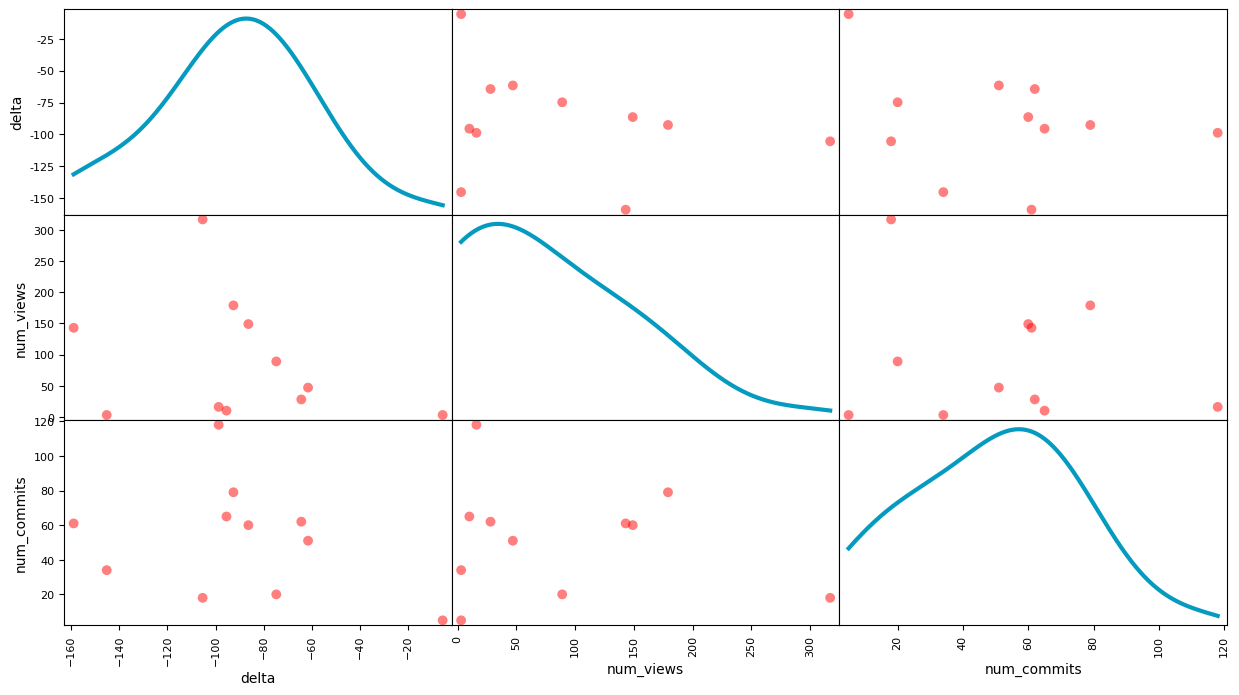

In [9]:
ax = scatter_matrix(pivot_table,
                    figsize=(15, 8),
                    diagonal='kde',
                    density_kwds=dict(color='#059ABF', linewidth=3),
                    s=200,
                    color='red')

--------------------------------------------------------------------------------




--------------------------------------------------------------------------------

In [10]:
connect.close()
print('Connection to SQLite closed')

Connection to SQLite closed


Можем ли мы сказать, что если у пользователя мало просмотров страниц, то он, скорее всего,
у вас мало коммитов?

Нет

Можем ли мы сказать, что если у пользователя мало просмотров страниц,
небольшая средняя разница между первым коммитом и крайним сроком лаборатории?

Нет

Можем ли мы сказать, что есть много пользователей с небольшим количеством коммитов и
мало с большим количеством коммитов?

Можно сказать, что пользователей с небольшим количеством коммитов больше, чем с малым. Однако для вопроса много ли их, нужно понимать, какое значение мы примем за "много".

Можем ли мы сказать, что есть много пользователей с небольшой средней разницей и
несколько с большой средней разницей?

Нет, но как и в предудыщем случае встает вопрос: какое значение мы примем за "много".